In [0]:
# Ignore this cell
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/datasets/finance_social/Dataset')
os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


['StockTwits',
 'Twitter',
 'ReutersNews',
 'twiters_label_data_Feb-02-2020.xlsx',
 'Stocktwits Label Model training with twiter data.ipynb',
 'github data',
 'INTENTS and UTTERANCE.yaml',
 'Keras_FNN_model.json',
 'finalized_Keras_model.sav',
 'Stocktwits Label Model training with twiter data - Final.ipynb',
 'Keras KNN test result 1.PNG',
 'Keras KNN test result 1a.PNG',
 'finalized_Keras_model_1.sav',
 'Keras_FNN_model_1.json',
 'Keras_FNN_model.h5',
 'Stocktwits Keras FNN for sentiment analysis-Final.ipynb',
 'finalized_SVM_model.sav',
 'chatbot_training.yaml',
 'stocktwits_sentiment_subjectivity_Feb-01-2020_p.xlsx',
 'twitter_ul.npy',
 'FinancialPrediction',
 'variant_filterer.csv']

In [0]:
from pathlib import Path
import json
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import html
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from keras.callbacks import ModelCheckpoint,CSVLogger
import spacy
import keras
from keras import models
from keras import layers
from keras import regularizers
print (keras.__version__)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

nltk.download('punkt')
from nltk import sent_tokenize, word_tokenize, wordpunct_tokenize

Using TensorFlow backend.


2.2.5
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
file_path = Path("StockTwits/AAPL.json")
stocktwits_dir = Path("StockTwits")
twitter_dir = Path("Twitter")
stocktwits_filename = 'stocktwits.pkl'

In [0]:
all_data = pd.read_pickle(stocktwits_filename)
print(all_data.shape)

(140509, 31)


In [0]:
all_data['char_length'] = all_data['body'].apply(lambda x: len(x))
all_data = all_data.loc[all_data['char_length'] >0,:] # drop rows with preprocessed text length < 0
all_data = all_data.reset_index(drop=True) # reset the index from 0 after dropping rows
all_data.shape

(137996, 32)

In [0]:
def preprocess(text):
  processed = re.sub(r'\B\$\s?\w+(\.\w+)?\b\s*', '', text)
  processed = re.sub(r',\s+','', processed) # commas not informative for sentiment
  processed = re.sub(r'\s', ' ', processed) # replace new line and tabspace with single space
  processed = re.sub('http\S+', '',  processed) # remove URLs
  processed = html.unescape(processed) # unescape html text
  return processed.strip()

In [0]:
sent_data = all_data.loc[:, ['id', 'ticker', 'symbols', 'body','sentiment', 'raw_body']]
sent_data['body'] = sent_data['body'].apply(preprocess)

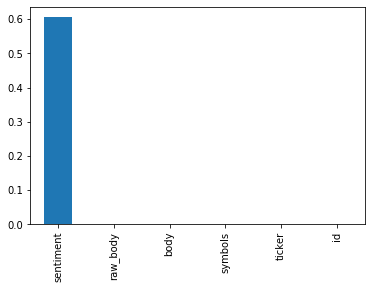

In [0]:
sent_data.isnull().mean().sort_values(ascending=False).plot(kind='bar')

(54435, 6)

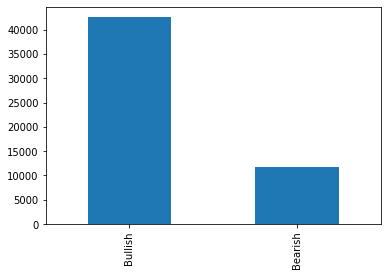

In [0]:
sent_data = sent_data.dropna(subset=['sentiment'])
sent_data = sent_data.reset_index(drop=True) # reset the index from 0 after dropping rows
sent_data['sentiment'].value_counts(dropna=False).plot(kind='bar')
sent_data.shape

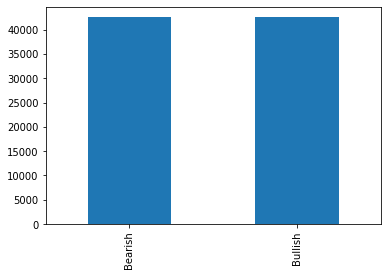

In [0]:
bullish = sent_data[sent_data['sentiment'] == 'Bullish']
bullish.shape
bearish = sent_data[sent_data['sentiment'] == 'Bearish']
bearish.shape
bearish_upsampled = utils.resample(bearish, 
                                 replace=True,     # sample with replacement
                                 n_samples=bullish.shape[0],    # to match majority class
                                 random_state=42)
sent_data = pd.concat([bullish,bearish_upsampled])
sent_data = sent_data.reset_index(drop=True) # reset the index from 0 after dropping rows
sent_data['sentiment'].value_counts(dropna=False).plot(kind='bar')

## 1.1 Word2Vec

In [0]:
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()

     |████████████████████████████████| 95.4MB 58.3MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.1.0-cp36-none-any.whl size=97126236 sha256=c01955ff2d1d9173234595a87c74af16a82379ab311a86c55eb9fdb2c30cb294
  Stored in directory: /tmp/pip-ephem-wheel-cache-1dnql995/wheels/c1/2c/5f/fd7f3ec336bf97b0809c86264d2831c5dfb00fc2e239d1bb01
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
# docs = sent_data['body'].apply(lambda x: nlp(x))
# docs.to_pickle('stocktwits_spacy.pkl')
docs = pd.read_pickle('stocktwits_spacy.pkl')
docs.shape

(85200,)

In [0]:
X = docs.apply(lambda x: x.vector)
X = np.array(X.tolist())
# y = sent_data['sentiment'].replace({'Bullish':1,'Bearish':-1}).astype('float32')
y = pd.get_dummies(sent_data['sentiment'])
print(X.shape, y.shape)

(85200, 300) (85200, 2)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [0]:
svm_clf=SVC(kernel="rbf",gamma='scale', C=1) 
svm_clf.fit(X_train,y_train)
y_pred = svm_clf.predict(X_test)


print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred)) 

In [0]:
W2V_DIM=X_train.shape[-1]
BATCH_SIZE=32
NUM_EPOCHS=50

In [0]:
model = models.Sequential()
model.add(layers.Dense(96, activation='relu', input_shape=(W2V_DIM,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 96)                28896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 41,410
Trainable params: 41,410
Non-trainable params: 0
_________________________________________________________________


In [0]:
filepath="weights-improvement-{val_acc:.2f}-{epoch:02d}.hdf5"
checkpoint      = ModelCheckpoint('/content/drive/My Drive/logs/'+filepath, 
                                  monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
csv_logger      = CSVLogger("image_classifier" +'.csv')
callbacks = [checkpoint,csv_logger]
optim = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, 
               validation_split=0.2, verbose=2,callbacks=callbacks)

Train on 54528 samples, validate on 13632 samples
Epoch 1/50
 - 10s - loss: 0.0892 - acc: 0.9638 - val_loss: 0.7095 - val_acc: 0.8592

Epoch 00001: val_acc did not improve from 0.86950
Epoch 2/50
 - 10s - loss: 0.0834 - acc: 0.9659 - val_loss: 0.6806 - val_acc: 0.8722

Epoch 00002: val_acc improved from 0.86950 to 0.87221, saving model to /content/drive/My Drive/logs/weights-improvement-02-0.87.hdf5
Epoch 3/50
 - 10s - loss: 0.0857 - acc: 0.9654 - val_loss: 0.6555 - val_acc: 0.8661

Epoch 00003: val_acc did not improve from 0.87221
Epoch 4/50
 - 10s - loss: 0.0827 - acc: 0.9653 - val_loss: 0.6966 - val_acc: 0.8677

Epoch 00004: val_acc did not improve from 0.87221
Epoch 5/50
 - 9s - loss: 0.0800 - acc: 0.9671 - val_loss: 0.7643 - val_acc: 0.8625

Epoch 00005: val_acc did not improve from 0.87221
Epoch 6/50
 - 10s - loss: 0.0823 - acc: 0.9666 - val_loss: 0.6531 - val_acc: 0.8695

Epoch 00006: val_acc did not improve from 0.87221
Epoch 7/50
 - 9s - loss: 0.0765 - acc: 0.9688 - val_loss: 

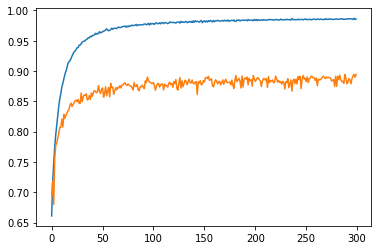

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [0]:
model_path= '/content/drive/My Drive/logs/0.89_96_64_32_2/weights-improvement-289-0.89.hdf5'
model = models.load_model(model_path)
model.summary()











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 96)                28896     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 37,250
Trainable params: 37,250
Non-trainable params: 0
_________________________________________________________________


In [0]:
preds = model.predict(X_test)
model.evaluate(X_test,y_test)

17040/17040 [==============================] - 1s 42us/step


[0.9585166866178384, 0.8890845070422535]

In [0]:
model.metrics_names

['loss', 'acc']

In [0]:
all_data['raw_body']

0         I&#39;m not a Republican (voted more dem in my...
1         Yahoo partnership puts Binance back in the Jap...
2         CAUTIONARY STATEMENT REGARDING http://www.conf...
3         / Yahoo! Inc. Bond files form 8-K - Other Even...
4         these big buys and volume picking up!! There s...
                                ...                        
137991    NEW ARTICLE : JEDI Mind Tricks: Esper Says Clo...
137992      Historic            after hours   The beginning
137993                                   boys we on our way
137994    There is no such thing!  who said &quot;too mu...
137995    Whats going on with ? Is losing that Pentagon ...
Name: raw_body, Length: 137996, dtype: object

In [0]:
# all_data['body'] = all_data['body'].apply(preprocess)
# ul_docs = all_data['body'].apply(lambda x: nlp(x))
# ul_X = ul_docs.apply(lambda x: x.vector)
# ul_X = np.array(ul_X.tolist())
# np.save('stocktwits_ul.npy', ul_X)
ul_X = np.load('stocktwits_ul.npy')
ul_X.shape

(137996, 300)

In [0]:
ul_y = model.predict(ul_X)
ul_labels = np.argmax(ul_y,axis=1)
labels= pd.Series(ul_labels).replace({0:'Bearish',1:'Bullish'})

In [0]:
all_data['bearish_score'] = ul_y[:,0]
all_data['bullish_score'] = ul_y[:,1]
all_data['sentiment_pred']= labels